<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [126]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.stats import spearmanr

<h1 style="text-align: center; font-weight: bold;"><u>Étape 1 Requêtes SQL</u></h1>

In [127]:
# Chemin vers la base de données SQLite
db_path = 'data/olist.db'

# Créer une connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

In [128]:
# Définir la requête SQL
# En excluant les commandes annulées, quelles sont les commandes
#  récentes de moins de 3 mois que les clients ont reçues avec au moins 3
#  jours de retard 
query1 = """
SELECT 
    o.order_id, 
    o.order_status, 
    o.order_purchase_timestamp, 
    o.order_delivered_customer_date, 
    o.order_estimated_delivery_date
FROM 
    orders o
WHERE 
    o.order_status != 'canceled'
    AND o.order_purchase_timestamp >= (
        SELECT DATE(MAX(order_purchase_timestamp), '-3 months')
        FROM orders
    )
    AND JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) >= 3;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query1, conn)

In [129]:
print(df.shape[0])

322


In [130]:
# Afficher les résultats
df.head()  # Affiche les 5 premières lignes du DataFrame

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,cfa4fa27b417971e86d8127cb688712f,delivered,2018-08-16 09:44:23,2018-08-29 01:41:41,2018-08-22 00:00:00
1,234c056c50619f48da64f731c48242b4,delivered,2018-08-14 14:49:15,2018-09-01 18:14:42,2018-08-23 00:00:00
2,8ad3f1d0f96992e43566c4c82c9f6c58,delivered,2018-07-17 21:25:29,2018-08-14 04:04:40,2018-08-03 00:00:00
3,7f579e203c931f3e8410103359c6d523,delivered,2018-08-02 18:09:27,2018-08-13 20:11:47,2018-08-09 00:00:00
4,cb6e441ff2ef574ce08d3709426f88ec,delivered,2018-08-08 19:27:03,2018-08-18 01:11:58,2018-08-15 00:00:00


In [131]:
# Définir la requête SQL
# Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
#  000Real sur des commandeslivrées via Olist ?
 
query2 = """
SELECT oi.seller_id, SUM(oi.price) AS total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
WHERE o.order_status = 'delivered'
GROUP BY oi.seller_id
HAVING total_revenue > 100000;
"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query2, conn)

In [132]:
print(df.shape[0])

17


In [133]:
# Afficher les résultats
# Augmenter le nombre de lignes affichées
pd.set_option('display.max_rows', None)
df.head()  # Affiche les 5 premières lignes du DataFrame

,seller_id,total_revenue
0,1025f0e2d44d7041d6cf58b6550e0bfa,138208.56
1,1f50f920176fa81dab994f9023523100,106655.71
2,46dc3b2cc0980fb8ec44634e21d2718e,122811.38
3,4869f7a5dfa277a7dca6462dcf3b52b2,226987.93
4,4a3ca9315b744ce9f8e9374361493884,196882.12


In [134]:
# Définir la requête SQL
 # Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
 # sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
 # produits) ?
query3 = """
WITH max_order_date AS (
    SELECT MAX(order_purchase_timestamp) AS max_date
    FROM orders
),
first_sale_per_seller AS (
    SELECT 
        oi.seller_id,
        MIN(o.order_purchase_timestamp) AS first_sale_date
    FROM 
        order_items oi
        JOIN orders o ON oi.order_id = o.order_id
    GROUP BY 
        oi.seller_id
),
sales_last_3_months AS (
    SELECT 
        oi.seller_id,
        COUNT(*) AS products_sold
    FROM 
        order_items oi
        JOIN orders o ON oi.order_id = o.order_id
        JOIN max_order_date m ON 1=1
    WHERE 
        o.order_purchase_timestamp >= DATE(m.max_date, '-3 months')
    GROUP BY 
        oi.seller_id
)
SELECT 
    fs.seller_id,
    fs.first_sale_date,
    sl.products_sold
FROM 
    first_sale_per_seller fs
    JOIN sales_last_3_months sl ON fs.seller_id = sl.seller_id
    JOIN max_order_date m ON 1=1
WHERE 
    fs.first_sale_date >= DATE(m.max_date, '-3 months')
    AND sl.products_sold > 30
;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query3, conn)

In [135]:
print(df.shape[0])

3


In [136]:
# Afficher les résultats
df.head()  # Affiche les 5 premières lignes du DataFrame

,seller_id,first_sale_date,products_sold
0,240b9776d844d37535668549a396af32,2018-07-17 13:48:59,36
1,81f89e42267213cb94da7ddc301651da,2018-08-08 12:45:12,52
2,d13e50eaa47b4cbe9eb81465865d8cfc,2018-08-04 09:09:37,69


In [137]:
# Définir la requête SQL
 # Question : Quels sont les 5 codes postaux, enregistrant plus de 30
 # reviews, avec le pire review score moyen sur les 12 derniers mois 
query4 = """
WITH max_order_date AS (
    SELECT MAX(order_purchase_timestamp) AS max_date
    FROM orders
),
filtered_reviews AS (
    SELECT 
        r.review_score,
        c.customer_zip_code_prefix
    FROM 
        order_reviews r
        JOIN orders o ON r.order_id = o.order_id
        JOIN customers c ON o.customer_id = c.customer_id
        JOIN max_order_date m ON 1=1
    WHERE 
        o.order_purchase_timestamp >= DATE(m.max_date, '-12 months')
),
reviews_aggregated AS (
    SELECT 
        customer_zip_code_prefix,
        COUNT(*) AS review_count,
        AVG(review_score) AS avg_review_score
    FROM 
        filtered_reviews
    GROUP BY 
        customer_zip_code_prefix
    HAVING 
        review_count > 30
)
SELECT 
    customer_zip_code_prefix,
    review_count,
    avg_review_score
FROM 
    reviews_aggregated
ORDER BY 
    avg_review_score ASC
LIMIT 5;

"""

# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query4, conn)

In [138]:
print(df.shape[0])

5


In [139]:
# Afficher les résultats
df.head(20)  # Affiche les 5 premières lignes du DataFrame

,customer_zip_code_prefix,review_count,avg_review_score
0,22753,47,2.808511
1,22770,37,3.135135
2,22793,90,3.233333
3,21321,36,3.277778
4,22780,37,3.351351


<h1 style="text-align: center; font-weight: bold;"><u>Étape 2 feature engineering</u></h1>

In [143]:
query = """
WITH max_date AS (
    SELECT MAX(order_purchase_timestamp) AS global_max_date
    FROM orders
),
customer_orders AS (
    SELECT 
        c.customer_unique_id,
        o.order_id,
        o.order_purchase_timestamp
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
),
payments AS (
    SELECT 
        co.customer_unique_id,
        MAX(co.order_purchase_timestamp) AS last_order_date,
        COUNT(DISTINCT co.order_id) AS frequency,
        SUM(op.payment_value) AS monetary
    FROM customer_orders co
    JOIN order_pymts op ON co.order_id = op.order_id
    GROUP BY co.customer_unique_id
),
rfm AS (
    SELECT 
        p.customer_unique_id,
        CAST(JULIANDAY(m.global_max_date) - JULIANDAY(p.last_order_date) AS INT) AS recency,
        p.frequency,
        ROUND(p.monetary, 2) AS monetary
    FROM payments p
    CROSS JOIN max_date m
)

SELECT *
FROM rfm
ORDER BY recency DESC;

"""
# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query, conn)

In [144]:
df.head()

,customer_unique_id,recency,frequency,monetary
0,4854e9b3feff728c13ee5fc7d1547e92,772,1,75.06
1,b7d76e111c89f7ebf14761390f0f7d17,772,1,136.23
2,009b0127b727ab0ba422f6d9604487c7,764,1,40.95
3,0eb1ee9dba87f5b36b4613a65074337c,744,1,109.34
4,2f64e403852e6893ae37485d5fcacdaf,744,1,39.09


<h1 style="text-align: center; font-weight: bold;"><u>Étape 2.1 Statistique</u></h1>

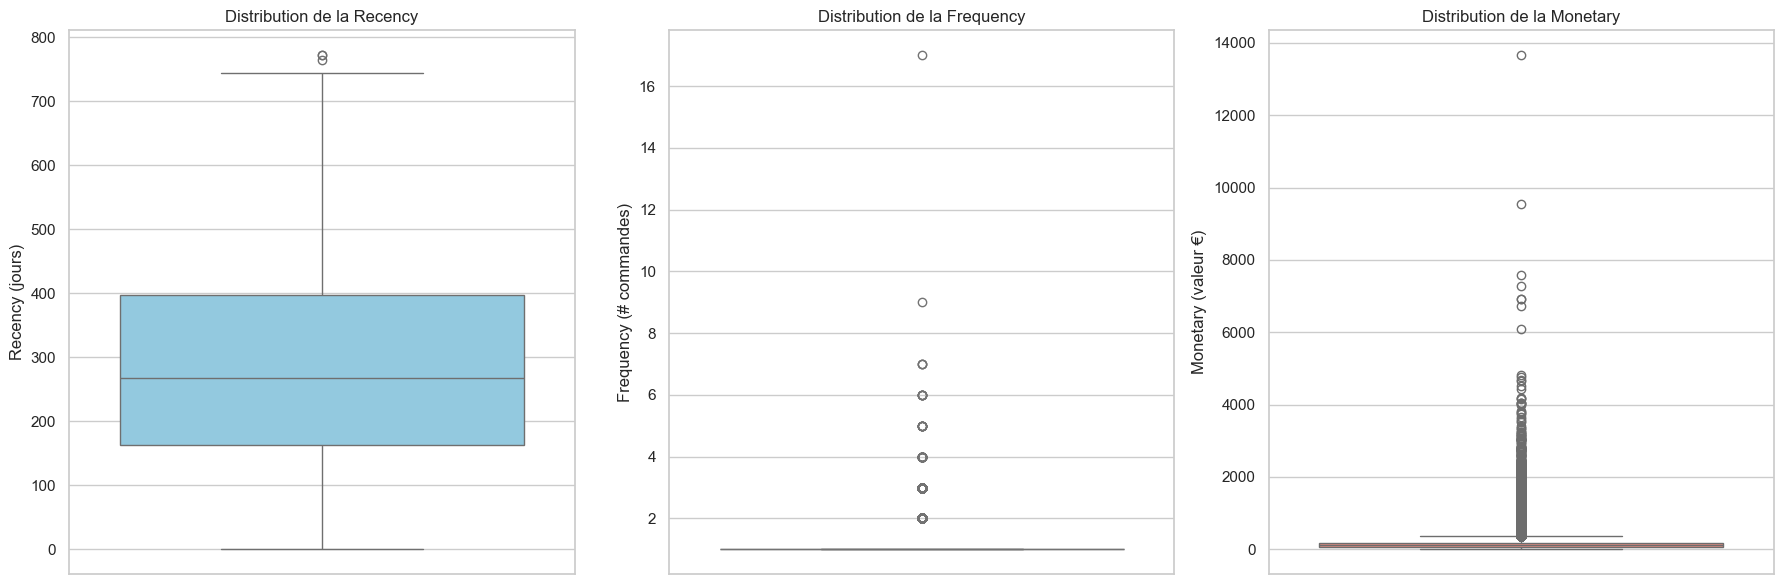

In [145]:
# Définir le style
sns.set(style="whitegrid")

# Créer la figure et les axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot Recency
sns.boxplot(y=df['recency'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribution de la Recency')
axes[0].set_ylabel('Recency (jours)')
axes[0].set_xlabel('')

# Boxplot Frequency
sns.boxplot(y=df['frequency'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution de la Frequency')
axes[1].set_ylabel('Frequency (# commandes)')
axes[1].set_xlabel('')

# Boxplot Monetary
sns.boxplot(y=df['monetary'], ax=axes[2], color='salmon')
axes[2].set_title('Distribution de la Monetary')
axes[2].set_ylabel('Monetary (valeur €)')
axes[2].set_xlabel('')

# Ajuster l'espacement
plt.tight_layout()
plt.show()

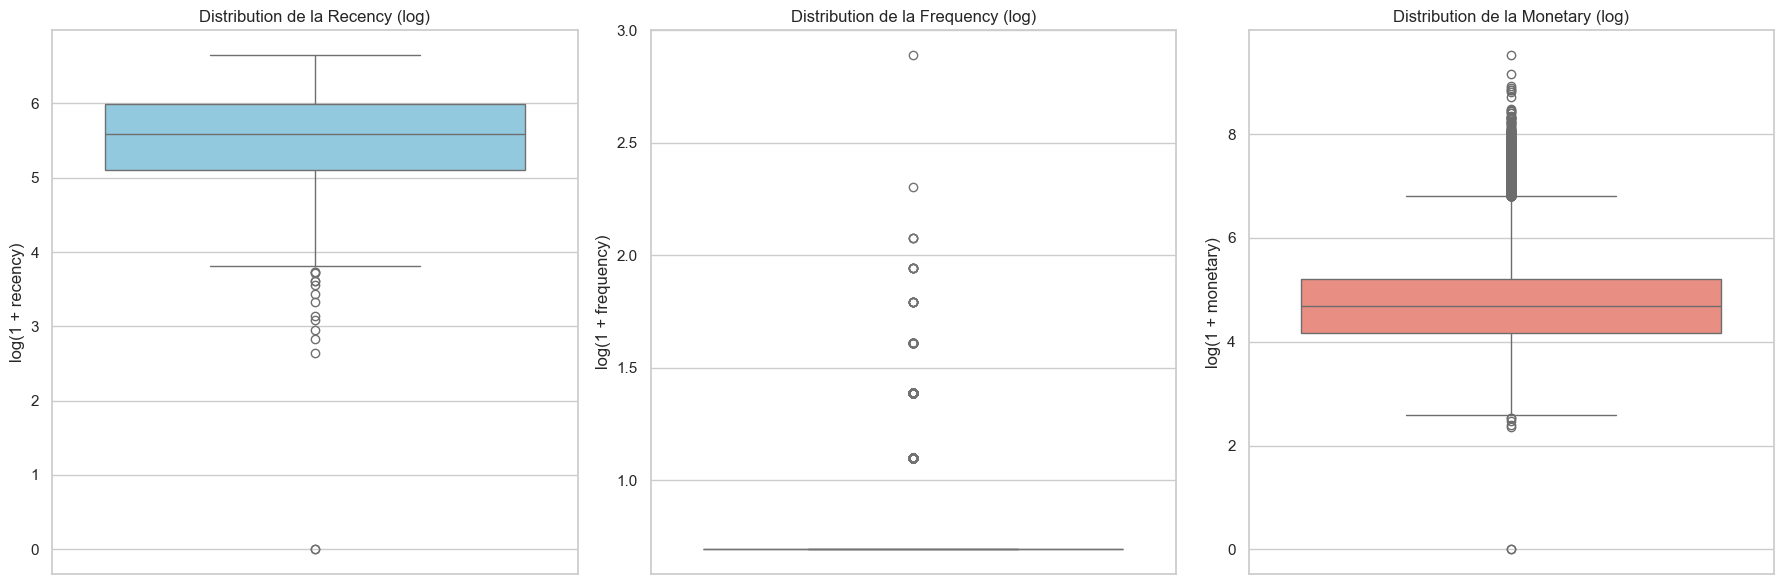

In [146]:
# Appliquer une transformation log1p
df_log = df.copy()
df_log['recency'] = np.log1p(df_log['recency'])
df_log['frequency'] = np.log1p(df_log['frequency'])
df_log['monetary'] = np.log1p(df_log['monetary'])

# Définir le style
sns.set(style="whitegrid")

# Créer la figure et les axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot Recency
sns.boxplot(y=df_log['recency'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribution de la Recency (log)')
axes[0].set_ylabel('log(1 + recency)')
axes[0].set_xlabel('')

# Boxplot Frequency
sns.boxplot(y=df_log['frequency'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution de la Frequency (log)')
axes[1].set_ylabel('log(1 + frequency)')
axes[1].set_xlabel('')

# Boxplot Monetary
sns.boxplot(y=df_log['monetary'], ax=axes[2], color='salmon')
axes[2].set_title('Distribution de la Monetary (log)')
axes[2].set_ylabel('log(1 + monetary)')
axes[2].set_xlabel('')

# Ajuster l'espacement
plt.tight_layout()
plt.show()

In [147]:
df[['recency', 'frequency', 'monetary']].describe()

,recency,frequency,monetary
count,96095.000000,96095.000000,96095.000000
mean,287.730756,1.034809,166.594226
std,153.407846,0.214385,231.428912
min,0.000000,1.000000,0.000000
25%,163.000000,1.000000,63.120000
50%,268.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,772.000000,17.000000,13664.080000


In [148]:
# Nombre total de clients
total_clients = len(df)

# Nombre de clients avec une seule commande (frequency == 1)
one_time_clients = len(df[df['frequency'] == 1])

# Pourcentage de clients ayant commandé une seule fois
percentage_one_time = (one_time_clients / total_clients) * 100

print(f"📊 Pourcentage de clients ayant commandé une seule fois : {percentage_one_time:.2f}%")

📊 Pourcentage de clients ayant commandé une seule fois : 96.88%


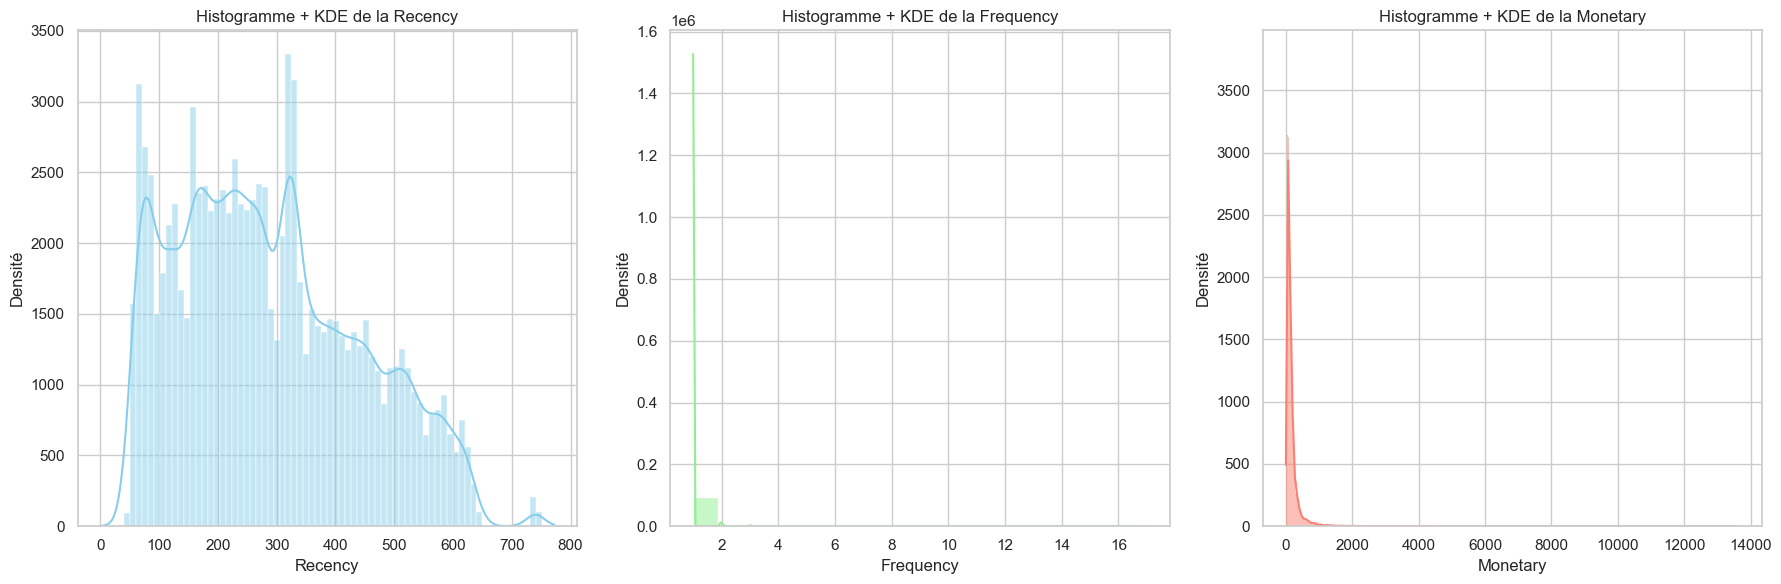

In [149]:
# Définir le style
sns.set(style="whitegrid")

# Créer la figure et les axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogramme + KDE Recency
sns.histplot(df['recency'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Histogramme + KDE de la Recency')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Densité')

# Histogramme + KDE Frequency
sns.histplot(df['frequency'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Histogramme + KDE de la Frequency')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Densité')

# Histogramme + KDE Monetary
sns.histplot(df['monetary'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Histogramme + KDE de la Monetary')
axes[2].set_xlabel('Monetary')
axes[2].set_ylabel('Densité')

# Ajuster l'espacement
plt.tight_layout()
plt.show()

<h1 style="text-align: center; font-weight: bold;"><u>Étape 2.2 Corrélation</u></h1>

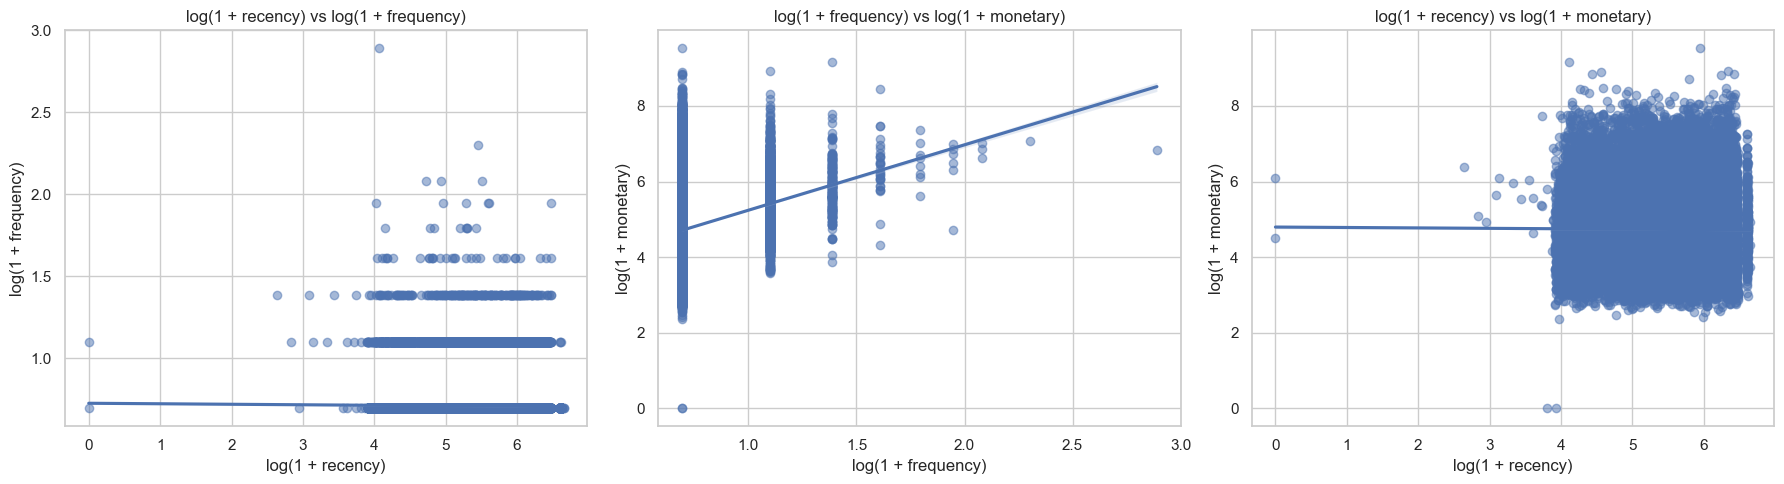

In [150]:
# Appliquer log1p
df_log = df.copy()
df_log['recency'] = np.log1p(df_log['recency'])
df_log['frequency'] = np.log1p(df_log['frequency'])
df_log['monetary'] = np.log1p(df_log['monetary'])

# Définir le style
sns.set(style="whitegrid")

# Créer la figure et les axes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot Recency vs Frequency
sns.regplot(x='recency', y='frequency', data=df_log, ax=axes[0], scatter_kws={'alpha':0.5})
axes[0].set_title('log(1 + recency) vs log(1 + frequency)')
axes[0].set_xlabel('log(1 + recency)')
axes[0].set_ylabel('log(1 + frequency)')

# Scatter plot Frequency vs Monetary
sns.regplot(x='frequency', y='monetary', data=df_log, ax=axes[1], scatter_kws={'alpha':0.5})
axes[1].set_title('log(1 + frequency) vs log(1 + monetary)')
axes[1].set_xlabel('log(1 + frequency)')
axes[1].set_ylabel('log(1 + monetary)')

# Scatter plot Recency vs Monetary
sns.regplot(x='recency', y='monetary', data=df_log, ax=axes[2], scatter_kws={'alpha':0.5})
axes[2].set_title('log(1 + recency) vs log(1 + monetary)')
axes[2].set_xlabel('log(1 + recency)')
axes[2].set_ylabel('log(1 + monetary)')

# Ajuster l'affichage
plt.tight_layout()
plt.show()

<h1 style="text-align: center; font-weight: bold;"><u>Recency vs Monetary</u></h1>

📊  Recency vs Monetary
Observation : la droite de régression est quasiment plate. Les points sont denses à droite (récence faible → clients récents).

Interprétation :

Aucune relation linéaire apparente.

Même après log, la distribution des clients récents est très concentrée, ce qui écrase toute tendance.

In [151]:
corr, p = spearmanr(df_log['recency'], df_log['monetary'])
print(f"Corrélation de Spearman : {corr:.3f} (p-value = {p:.3e})")

Corrélation de Spearman : -0.015 (p-value = 5.471e-06)


🔢 Corrélation de Spearman : -0.015
La valeur est proche de zéro → pas de relation monotone détectable entre recency et monetary.

Le signe (ici négatif) indique une très légère tendance : quand recency augmente, monetary tendrait très faiblement à diminuer… mais c’est négligeable en pratique.

📊 p-value = 5.471e-06 (soit ≈ 0.000005)
La p-value faible (< 0.05) indique que la corrélation observée est statistiquement significative.

⚠️ Mais attention : significatif ≠ important. Cela veut seulement dire que ce tout petit effet est réel, pas dû au hasard, mais il reste très faible (–0.015).

✅ Conclusion :
Corrélation très faible → les variables recency et monetary n’évoluent pas ensemble de manière monotone.

Significatif, mais non pertinent → ce résultat n’apporte aucune valeur explicative utile pour l’analyse RFM.

<h1 style="text-align: center; font-weight: bold;"><u>Frequency vs Monetary</u></h1>

📊 Frequency vs Monetary
Observation : la droite de régression a une pente positive. La dispersion des points suit grossièrement cette tendance.

Interprétation :

Il y a une relation linéaire positive modérée.

Plus un client achète souvent, plus il dépense (ce qui est intuitif).

Ce couple est le plus corrélé des trois, et une régression linéaire semble ici justifiée.

In [152]:
# Calcul de la corrélation de Pearson
corr, p = pearsonr(df_log['frequency'], df_log['monetary'])

print(f"Corrélation de Pearson : {corr:.3f} (p-value = {p:.3e})")

Corrélation de Pearson : 0.167 (p-value = 0.000e+00)


📊 Corrélation de Pearson : 0.167 (p-value = 0.000e+00)

✅ 1. Force de la corrélation (corr = 0.167) :
Le coefficient 0.167 indique une corrélation positive faible entre frequency et monetary :

Plus un client achète fréquemment (frequency), plus il tend à dépenser globalement davantage (monetary).

Toutefois, la relation est faible : il existe de nombreuses exceptions (clients fréquents qui dépensent peu, ou peu fréquents mais dépensiers).

🧪 2. Significativité statistique (p-value ≈ 0) :
La p-value est très proche de zéro, ce qui signifie que la corrélation est statistiquement significative.

En d'autres termes, il est très peu probable que cette corrélation soit due au hasard.

🧠 Conclusion :
Même si la corrélation est faible, elle est significative. Cela signifie qu’il existe une relation linéaire modérée mais réelle entre la fréquence des achats et le montant total dépensé, ce qui peut être utile pour un scoring client (par exemple dans une analyse RFM).

<h1 style="text-align: center; font-weight: bold;"><u>Recency vs Frequency</u></h1>

📊 Recency vs Frequency
Observation : la droite de régression est quasiment horizontale, et les points sont fortement regroupés autour de valeurs faibles de frequency.

Interprétation :

Très faible corrélation linéaire.

Visuellement, pas de relation linéaire claire : la fréquence ne varie pas de façon significative avec la récence.

Comportement typique : clients peu récents ont souvent acheté une seule fois (fréquence = 1).

In [153]:
corr, p = spearmanr(df_log['recency'], df_log['frequency'])
print(f"Corrélation de Spearman : {corr:.3f} (p-value = {p:.3e})")

Corrélation de Spearman : -0.021 (p-value = 2.798e-11)


🔍 Corrélation de Spearman : -0.021 (p-value = 2.798e-11)
💡 Ce que cela signifie :
Corrélation de Spearman = −0.021 :

Très proche de 0 → il n’existe pratiquement aucune association monotone entre recency et frequency.

Le signe négatif indique qu’à peine (et très faiblement), plus un client est ancien (forte recency), moins il a acheté fréquemment, mais ce lien est négligeable.

p-value très faible (≈ 0.000000000028) :

Cela indique que le résultat est statistiquement significatif.

Mais attention : significatif ≠ important.

La taille de l’effet (corrélation ≈ -0.02) est minuscule, donc pas pertinente en pratique, même si détectée par le test à cause de la grande taille de l’échantillon.

🧠 Conclusion
✅ La relation est statistiquement significative, mais

❌ Pas de relation monotone forte ou exploitable entre recency et frequency.

✅ Conclusion générale

✅ Une relation linéaire raisonnable est visible uniquement entre frequency et monetary.

❌ Aucune linéarité entre recency et les deux autres dimensions.

Cela confirme les tests statistiques (faible corrélation de Spearman ou Pearson pour recency

🔁 Recency (nombre de jours depuis la dernière commande)
Min = 0 → certains clients ont passé une commande aujourd’hui (par rapport à la date max de ta base).

Max = 772 → certains clients n’ont pas commandé depuis plus de 2 ans.

Moyenne ≈ 288 jours, Médiane = 268 jours → la majorité n’a pas commandé depuis environ 9 mois.

Interprétation : la base contient beaucoup de clients inactifs ou peu récents.

🔂 Frequency (nombre de commandes distinctes)
Min = 1, 25%/50%/75% = 1 → au moins 75 % des clients n’ont commandé qu’une seule fois.

Max = 17 → très peu de clients fidèles (multi-acheteurs).

Moyenne ≈ 1.03 → presque tous les clients sont des acheteurs uniques.

Interprétation : Visiblement la fidélité des clients est très faible.

💰 Monetary (valeur monétaire cumulée des commandes)
Min = 0 → certains clients ont des paiements nuls (annulations, remboursements ?).

Médiane = 108 €, Moyenne ≈ 167 €, mais Max = 13 664 € → très forte asymétrie (quelques gros clients tirent la moyenne vers le haut).

Interprétation : la distribution est très déséquilibrée (longue traîne), il faut probablement la transformer (e.g. log).

✅ Conclusion

Il y a beaucoup de clients inactifs (forte récence).

Presque tous sont des acheteurs uniques.

Les dépenses sont concentrées sur une minorité.

📊 Résumé des statistiques utiles

| RFM       | Min | 25% | 50% | 75% | Max   |
|-----------|-----|-----|-----|-----|--------|
| Recency   | 0   | 163 | 268 | 397 | 772    |
| Frequency | 1   | 1   | 1   | 1   | 17     |
| Monetary  | 0   | 63  | 108 | 183 | 13664  |


In [154]:
# Récence : plus c'est petit, mieux c'est → 4 = client très récent
df['R_score'] = pd.qcut(df['recency'], q=4, labels=[4, 3, 2, 1]).astype(int)

# Fréquence : plus c'est élevé, mieux c'est
df['F_score'] = pd.qcut(df['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)

# Monétaire : plus c'est élevé, mieux c'est
df['M_score'] = pd.qcut(df['monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)


In [155]:
df['RFM_score'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)


In [156]:
def segment_rfm(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Fidèles'
    elif r == 4:
        return 'Nouveaux clients'
    elif f >= 3 and m >= 3:
        return 'Clients rentables'
    elif r <= 2 and f <= 2:
        return 'À risque'
    elif r <= 2 and f >= 3:
        return 'À réactiver'
    else:
        return 'Autres'

df['segment'] = df.apply(segment_rfm, axis=1)


In [157]:
df['segment'].value_counts()

segment
À risque             46677
Fidèles              41084
Champions             5620
Autres                1371
Clients rentables     1165
À réactiver            178
Name: count, dtype: int64

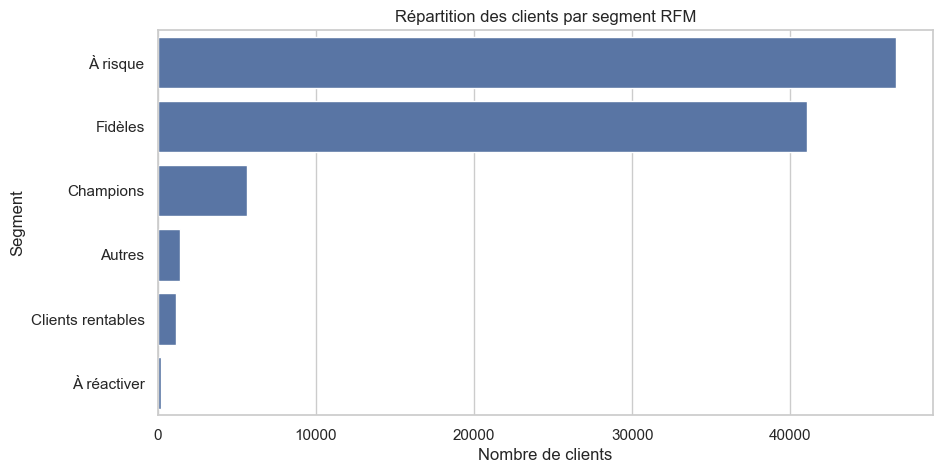

In [158]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='segment', order=df['segment'].value_counts().index)
plt.title('Répartition des clients par segment RFM')
plt.xlabel('Nombre de clients')
plt.ylabel('Segment')
plt.show()

| Segment              | Interprétation                                                                 | Taille  | Action recommandée                                                           |
|----------------------|--------------------------------------------------------------------------------|---------|-------------------------------------------------------------------------------|
| À risque             | Clients qui ont acheté il y a longtemps, peu souvent, et avec un panier moyen faible. | 46 677  | ⚠️ À relancer par des promotions ciblées, newsletters, ou offres de retour.   |
| Fidèles              | Clients avec une bonne fréquence d’achat mais pas forcément récents.          | 41 084  | ✅ Les entretenir : programme fidélité, offres spéciales, personnalisation.   |
| Champions            | Clients récents, fréquents, avec un bon panier moyen.                         | 5 620   | 👑 À choyer ! Offres VIP, accès exclusif, ambassadeurs de la marque.         |
| Autres               | Clients moyens ou nouveaux sans comportement tranché.                         | 1 371   | 🔍 À observer, potentiellement à faire monter en fidélité.                   |
| Clients rentables    | Clients avec un panier moyen élevé, mais pas forcément récents ou fréquents. | 1 165   | 💰 Mettre en avant des offres premium, ou ventes privées.                    |
| À réactiver          | Clients avec un bon historique, mais qui n'ont pas acheté récemment.          | 178     | ⏳ Campagnes de réactivation, rappel produits ou avantages non utilisés.     |


In [173]:
# Fermer la connexion à la base de données
conn.close()